# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
# Your work here.

### #1 Is the distribution of body temperatures normal?

In [3]:
df.head(5)

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


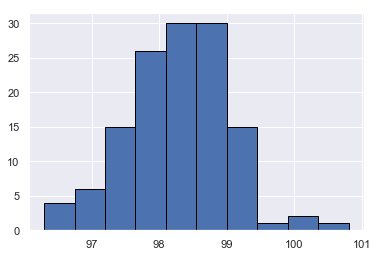

In [31]:
# import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# set default Seaborn style
sns.set()

# plot histogram of temperature
_ = plt.hist(df['temperature'], edgecolor='black')

plt.show()

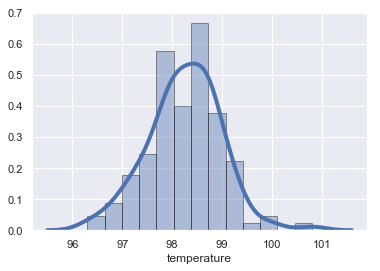

In [30]:
# seaborn histogram
sns.distplot(df['temperature'], hist=True, kde=True, 
             hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4})

From the first histogram, it looks approximately normal but I decided to further test it with the Seaborn histogram plot (see above). 

With this distplot, we are able to create a both a histogram and a density plot, which is a smoothed, continuous version of the histogram estimated from the data. From the shape, we are able to comfirm that the curve appears to be approximately normal. 

To take it one step further, we will use an Cumulative Disribution Function to assess the temperatures 

In [34]:
import numpy as np
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [36]:
mean_temp = np.mean(df['temperature'])
std_temp = np.std(df['temperature'])

# Sample out of a normal distribution with mean and std
temp_samples = np.random.normal(mean_temp, std_temp, 10000)

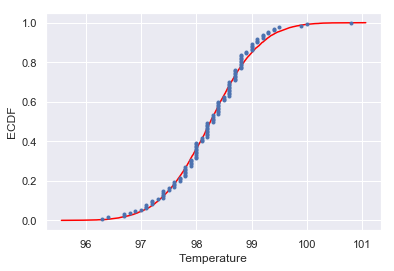

In [43]:
x_theor, y_theor = ecdf(temp_samples)
x, y = ecdf(df['temperature'])

plt.plot(x_theor, y_theor, color='red')
plt.plot(x, y, marker='.', linestyle='none')

_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')

plt.show()

So what did we just do? 

First, we took the mean and standard deviation of the temperature data and then created a theoretical distribution from 10,000 samples. 

Next, we plotted a theoretical CDF (cumulative distribution function) and an ECDF of the data. From the figure above, the data points fall in line nicely with the theoretical CDF, suggesting that temperature is indeed normally distributed.  

## #2 Is the sample size large? Are the observations independent?

In [45]:
# call shape, which returns total number of rows and columns
df.shape[0]

130

There are 130 samples in this dataset.

The Central Limit Theorem states the following:
- the sample mean follows approximately the normal distribution with mean µ and standard deviation √σ/n, where µ and σ are the mean and standard deviation of the population from where the sample was selected.
-  The sample size n has to be large (usually n ≥ 30) if the population from where the sample is taken is nonnormal. If the population follows the normal distribution then the sample size n can be either small or large.
(http://www.stat.ucla.edu/~nchristo/introeconometrics/introecon_central_limit_theorem.pdf)

Since our sample size is greater than 30, we can assume that the sample size is large enough. 

With the assumption that this data set was the result of a reasonably random selection process, and that 130 is less than 10% of the population, it can be said that the observations are independent of each other. 

## #3 Is the true population mean really 98.6 degrees F?

In [47]:
# First, try a bootstrap hypothesis test

- Null Hypothesis: The true mean temperature for the population is 98.6 degrees fahrenheit
- Alternative Hypothesis: The true mean temperature for the population is NOT 98.6 degrees fahrenheit

In [92]:
# mean temperature of the observated data
mean_temp

98.24923076923078

In [66]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [67]:
bs_replicates = draw_bs_reps(df['temperature'], np.mean, size=10000)

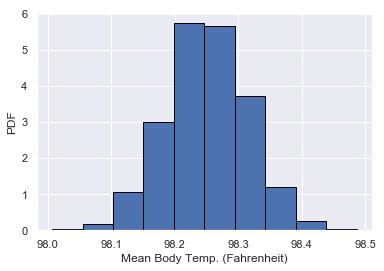

In [74]:
_ = plt.hist(bs_replicates, density=True, edgecolor='black')
_ = plt.xlabel('Mean Body Temp. (Fahrenheit)')
_ = plt.ylabel('PDF')
plt.show()

In [82]:
# translate the observed temperature to 98.6 degrees Fahrenheit 
translated_temp = df['temperature'] - np.mean(df['temperature']) + 98.60

In [84]:
bs_translate_replicates = draw_bs_reps(translated_temp, np.mean, 10000)

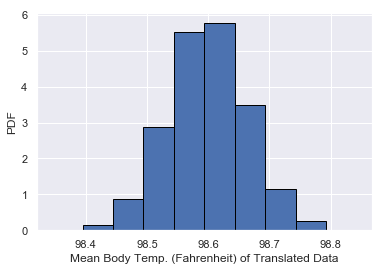

In [86]:
_ = plt.hist(bs_translate_replicates, density=True, edgecolor='black')
_ = plt.xlabel('Mean Body Temp. (Fahrenheit) of Translated Data')
_ = plt.ylabel('PDF')
plt.show()

In [90]:
# confidence interval of a statistic
ci_temp = np.percentile(bs_translate_replicates, 5.0)
ci_temp

98.49307692307691

In [91]:
np.mean(df['temperature']) < ci_temp

True

In [88]:
# Compute fraction of replicates that are less than observered body temperature
p = np.sum(bs_translate_replicates <= np.mean(df['temperature'])) / 10000
print('p = ', p)

p =  0.0
